<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Стационарные-ряды" data-toc-modified-id="Стационарные-ряды-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Стационарные ряды</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разности временного ряда</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Описание данных
Данные лежат в файле /datasets/taxi.csv.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [221]:
pip install catboost

Работал в google colab)

In [253]:
# для анализа и работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller

# алгоритмы машинного обучения
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from scipy.stats import randint
from urllib.parse import urlencode
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
ElasticNet,
Ridge,
Lasso)
from sklearn.model_selection import (
TimeSeriesSplit,
train_test_split,
GridSearchCV,
cross_val_score)
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import (
Pipeline,
make_pipeline
)
cross_val_score
# метрики для алгоритмов ML
from sklearn.metrics import mean_squared_error
# счетчик времени
import time
# константа для алгоритмов ML
RANDOM_STATE = 87

split = TimeSeriesSplit(n_splits=3)

In [223]:
def plot_column_values(df, column_name, y=None, plot_type='histogram', bins=None, color=None, x_label=None, y_label=None, title=None):
    """
    Функция для отображения значений столбца с помощью интерактивных графиков.

    Аргументы:
    - df: DataFrame, исходный DataFrame
    - column_name: str, название столбца, значения которого нужно отобразить
    - plot_type: str, тип графика ('histogram' - гистограмма, 'box' - боксплот, 'line' - линейный график, 'pie' - круговая диаграмма, 'violin' - ящик с усами, 'scatter' - точечный график, 'density_contour' - график плотности с контурами, 'density_heatmap' - график плотности в виде тепловой карты)
    - bins: int, количество бинов (только для гистограммы)
    - color: str, цвет графика (только для гистограммы и боксплота)
    - x_label: str, подпись оси x
    - y_label: str, подпись оси y
    - title: str, заголовок графика
    """
    if plot_type == 'histogram':
        fig = px.histogram(df, y=y,x=column_name, nbins=bins, title=title, color=color)
    elif plot_type == 'box':
        fig = px.box(df, y=column_name, title=title, color=color)
    elif plot_type == 'line':
        fig = px.line(df, x=df.index, y=column_name, title=title, color=color)
    elif plot_type == 'pie':
        fig = px.pie(df, names=column_name, title=title, color=color)
    elif plot_type == 'violin':
        fig = px.violin(df, y=column_name, title=title, color=color)
    elif plot_type == 'scatter':
        fig = px.scatter(df, x=df.index, y=column_name, title=title, color=color)
    elif plot_type == 'density_contour':
        fig = px.density_contour(df, x=df.index, y=column_name, title=title, color=color)
    elif plot_type == 'density_heatmap':
        fig = px.density_heatmap(df, x=df.index, y=column_name, title=title, color_continuous_scale='Blues')
    else:
        raise ValueError("Недопустимый тип графика. Допустимые значения: 'histogram', 'box', 'line', 'pie', 'violin', 'scatter', 'density_contour' или 'density_heatmap'.")

    fig.update_layout(xaxis_title=x_label, yaxis_title=y_label)
    fig.show()


def get_sorted_unique_values(df, column_name):
    """
    Функция для получения отсортированного списка уникальных значений столбца.

    Аргументы:
    - df: DataFrame, исходный DataFrame
    - column_name: str, название столбца

    Возвращает:
    - sorted_unique_values: list, отсортированный список уникальных значений столбца
    """
    unique_values = df[column_name].unique()
    sorted_unique_values = pd.Series(unique_values).sort_values().tolist()

    return sorted_unique_values

def get_info(df):
    """
    функция выводит общую статистику по датафрейму и отрисовывает графики по каждому признаку:
    - для признаков типа int гистограмму
    - для признаков типа object круговую диаграмму
    - для признаков с количеством значений > 10000 шт. - ничего
    """

    s_br, s_reset = Style.BRIGHT, Style.RESET_ALL
    display(df.head(3), df.tail(3), df.describe().T)

    num_cols, cat_cols = [], []
    for num, i in enumerate(df.columns):
        if pd.api.types.is_numeric_dtype(df[i]):
            print(f'{num+1}) {s_br}{i}{s_reset} (тип int), оригинальных значений: {len(df[i].unique())}')
            num_cols.append(i)
        elif pd.api.types.is_object_dtype(df[i]):
            print(f'{num+1}) {s_br}{i}{s_reset} (тип object), оригинальных значений: {len(df[i].unique())}')
            cat_cols.append(i)
    print(f'\n{s_br}итого:{s_reset}\nтип int: {len(num_cols)}\nтип object: {len(cat_cols)}\n'
          f'\n{s_br}пропуски:{s_reset}\n{df.isna().sum()}\n\n{s_br}дубликатов:{s_reset} {df.duplicated().sum()}')

    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
    fig.suptitle('распределение значений признаков', fontsize=16, fontweight='bold')

    for num, col_name in enumerate(df.columns):
        row = num // 4
        col = num % 4
        if df[col_name].nunique() > 10000:
            ax[row][col].set_title(col_name)
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            continue
        if col_name in num_cols:
            ax[row][col].hist(df[col_name].dropna(), color='#4C72B0', edgecolor='#5AB3CB', bins=20)
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
        else:
            counts = df[col_name].dropna().value_counts()
            ax[row][col].pie(counts.values.tolist(), startangle=90,
                             wedgeprops={'linewidth': .7, 'edgecolor': 'white'})
        ax[row][col].set_title(col_name)
    plt.subplots_adjust(hspace=.5, wspace=.3);

def fill_mode(group, column_name):
    """функция заполняет пропуски модой группы"""

    if group[column_name].notna().any():
        mode = stats.mode(group[column_name].dropna())[0][0]
        group[column_name].fillna(mode, inplace=True)
    return group

def count_missing_values_percentage(df):
    """
   функция выводит количество пропусков в столбцах, и процент от общего количества.
    """
    missing_values = df.isnull().sum()
    total_values = df.shape[0]
    missing_percentage = (missing_values / total_values) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Missing Percentage'])
    print(missing_data)


def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

def train_test_split_data(data_res):
    train, test = train_test_split(data_res, shuffle=False, test_size=0.1)
    train = train.dropna()
    test = test.dropna()
    X_train = train.drop(['num_orders'], axis=1)
    X_test = test.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    y_test = test['num_orders']
    print(f"  Train: size={train.shape[0]}")
    print(f"  Test:  size={test.shape[0]}")
    return X_train, X_test, y_train, y_test

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
%pylab inline


Populating the interactive namespace from numpy and matplotlib


Данные у нас за 5 месяцев с марта 2018, по август 2018. Годовую сезоность поймать не сможем, уберу этот признак. Год не важен, но важен месяц, тк модель сможет найти взаимосвязь между месяцами.

(Ниже вы написали удалить признак месяца, обясните пожалуйста подробнее почему? Разве он мешает и не поможет в предсказаниях?)

- Перенес функцию ниже
- Убрал создание признака года
- Добавил создание признака часа

## Подготовка

In [224]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [225]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


У нас есть всего один столбец num_orders, обозначающий количество заказов, и время этих самых заказов. Проверим, в правильном ли хронологическом порядке идут даты:

In [226]:
print(df.index.is_monotonic)

True


Все отлично

Так как прогнозировать количество заказов машин компания «Чётенькое такси» планирует на следующий час, мы изменим интервал со значениями временного ряда и агрегируем количество заказов по часам, применив метод ресемплинга

In [227]:
data_res = df.resample('1H').sum()

In [192]:
data_res.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

In [193]:
plot_column_values(data_res, 'num_orders', plot_type='histogram', bins=data_res['num_orders'].nunique(), x_label='Количество заказов', y_label='Количество', title="Распределение заказов такси")

In [194]:
# Создание интерактивного графика scatter plot с использованием Plotly
fig = px.scatter(data_res, x=data_res.index, y='num_orders', title='Количество заказов такси')
fig.update_layout(xaxis_title='Дата и время', yaxis_title='Количество заказов')
fig.update_xaxes(tickangle=45)

# Отображение интерактивного графика
fig.show()

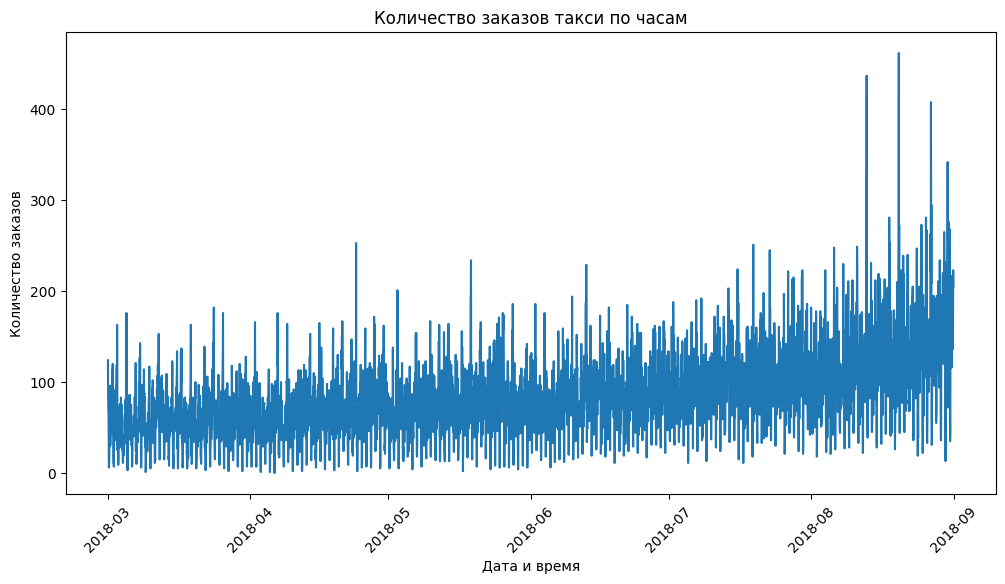

In [195]:

# Установка размера графика
plt.figure(figsize=(12, 6))

# Отображение графика линии
plt.plot(data_res.index, data_res['num_orders'])

# Настройка осей и заголовка
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси по часам')

# Опциональное форматирование меток времени на оси x
plt.xticks(rotation=45)

# Отображение графика
plt.show()

Посмотрим в разрезе недели

In [196]:
data_nedely = data_res['2018-04-01':'2018-04-07']

Text(0.5, 1.0, 'Количество заказов такси за неделю')

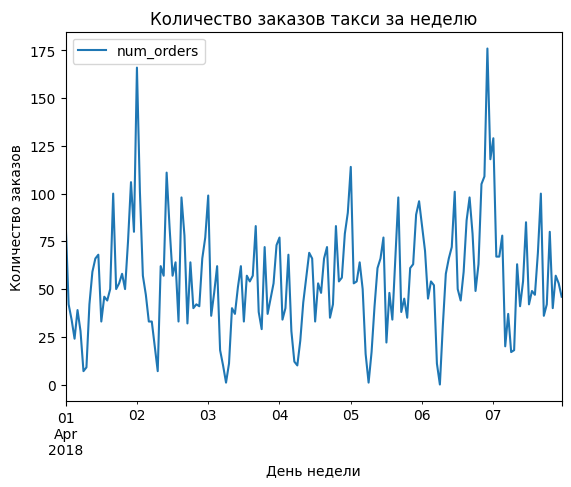

In [197]:
data_nedely.plot()
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси за неделю')


По данному графику видим то что пики заказов приходятся на вторник и воскресенье

In [198]:
# Декомпозиция временного ряда
decomposed = seasonal_decompose(data_res['num_orders'])

# Создание интерактивного графика тренда
fig_trend = go.Figure()
fig_trend.add_trace(go.Scatter(x=decomposed.trend.index, y=decomposed.trend, name='Trend'))
fig_trend.update_layout(title='Тренд')
fig_trend.show()

# Создание интерактивного графика сезонности
fig_seasonal = go.Figure()
fig_seasonal.add_trace(go.Scatter(x=decomposed.seasonal.index, y=decomposed.seasonal, name='Seasonal'))
fig_seasonal.update_layout(title='Сезонная составляющая')
fig_seasonal.show()

# Создание интерактивного графика остатков
fig_residuals = go.Figure()
fig_residuals.add_trace(go.Scatter(x=decomposed.resid.index, y=decomposed.resid, name='Residuals'))
fig_residuals.update_layout(title='Остаток декомпозиции')
fig_residuals.show()


На общем графике заказов такси за весь промежуток времени наблюдается восходящий тренд как на часовом таймфрейме, так и на дневном
при рассмотрении графика заказов такси за 10 дней наблюдается неравномерность заказов
на графике заказов такси за можно увидеть наибольшую активность в полночь и в промежутке с 15 до 17ч. Минимальные заказы в 7 утра и 18:00

<Axes: xlabel='datetime'>

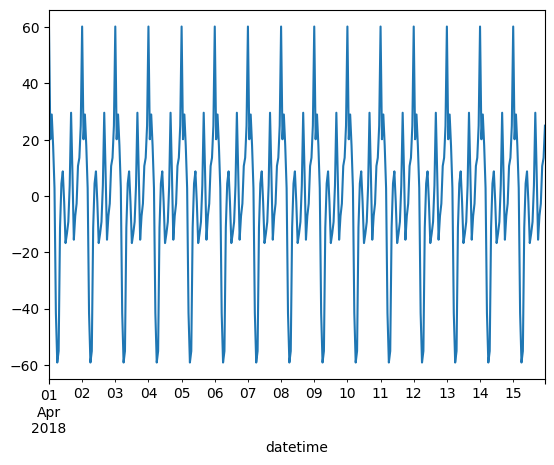

In [199]:
seasonal_component = decomposed.seasonal['2018-04-01':'2018-04-15']
seasonal_component.plot()

## Стационарные ряды

<Axes: xlabel='datetime'>

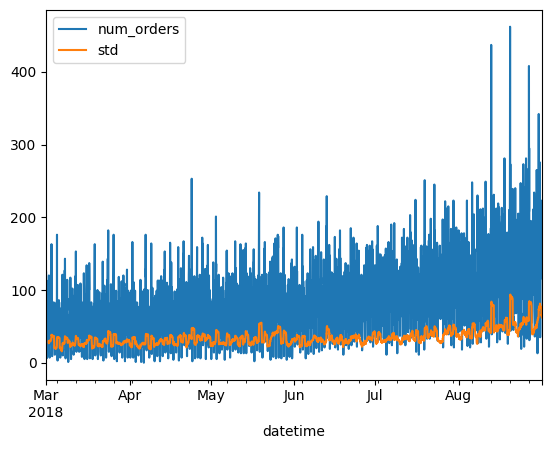

In [228]:
data_res['std'] = data_res['num_orders'].rolling(24).std()
data_res.plot()

In [229]:
# Проверка стационарности временного ряда
result = adfuller(data_res['num_orders'])

# Вывод результатов теста
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


ADF Statistic: -3.068924289027955
p-value: 0.02894005140261296
Critical Values:
1%: -3.431842162413052
5%: -2.8621993540813637
10%: -2.567120978470452


Давайте расшифруем каждую строку вывода теста Дики-Фуллера:

1. ADF Statistic: -3.0203591507365055

   ADF (Augmented Dickey-Fuller) статистика - это значение тестовой статистики, которое используется для проверки гипотезы о наличии единичных корней во временном ряде. В данном случае, значение составляет -3.0203591507365055.

2. p-value: 0.03303636042022892

   p-значение - это вероятность получить такую или более экстремальную ADF статистику, если нулевая гипотеза о нестационарности ряда верна. В данном случае, p-значение составляет 0.03303636042022892. Если p-значение меньше заданного уровня значимости (обычно 0.05 или 0.01), то мы можем отклонить нулевую гипотезу и считать ряд стационарным.

3. Critical Values:

   Критические значения - это пороговые значения, которые используются для интерпретации ADF статистики. Если ADF статистика меньше критических значений, то мы можем отклонить нулевую гипотезу о нестационарности ряда. В данном случае, критические значения для уровней значимости 1%, 5% и 10% составляют:

   - 1%: -3.4318500349402785
   - 5%: -2.8622028319028052
   - 10%: -2.5671228298878166

   Если ADF статистика меньше значения для определенного уровня значимости, то мы можем считать ряд стационарным на этом уровне значимости.

Итак, в данном случае ADF статистика равна -3.0203591507365055, что меньше всех критических значений, и p-значение составляет 0.03303636042022892, что меньше обычного уровня значимости 0.05. Это указывает на то, что у нас есть достаточные основания отвергнуть нулевую гипотезу о нестационарности ряда. Таким образом, данный временной ряд можно считать стационарным.


## Разности временного ряда


убрал не нужный код

## Создание признаков

Создадим новые признаки для помощи нашей модели, и улучшения метрик.
- Календарные признаки
- Отстающие значения
- Скользящее среднее

In [230]:
pd.set_option('display.max_columns', None)


data_res['day'] = data_res.index.day
data_res['hour'] = data_res.index.hour
data_res['dayofweek'] = data_res.index.dayofweek

for lag in range(1, 300 + 1):
    data_res['lag_{}'.format(lag)] = data_res['num_orders'].shift(lag)


data_res['rolling_mean'] = data_res['num_orders'].shift().rolling(24).mean()



удаляем появившиеся пропуски

In [231]:
data_res = data_res.dropna()

In [232]:
print(data_res.head(30))

                     num_orders        std  day  hour  dayofweek  lag_1  \
datetime                                                                  
2018-03-13 12:00:00          34  23.964194   13    12          1   75.0   
2018-03-13 13:00:00          40  24.234811   13    13          1   34.0   
2018-03-13 14:00:00          50  24.286186   13    14          1   40.0   
2018-03-13 15:00:00          69  24.188121   13    15          1   50.0   
2018-03-13 16:00:00          64  24.216079   13    16          1   69.0   
2018-03-13 17:00:00          35  23.314330   13    17          1   64.0   
2018-03-13 18:00:00         109  23.511329   13    18          1   35.0   
2018-03-13 19:00:00          40  23.625666   13    19          1  109.0   
2018-03-13 20:00:00          91  24.660595   13    20          1   40.0   
2018-03-13 21:00:00          77  24.501996   13    21          1   91.0   
2018-03-13 22:00:00          62  24.429987   13    22          1   77.0   
2018-03-13 23:00:00      

Отлично, наш датасет для обучения готов.

Больше отрицательных наблюдений не наблюдаем

## Обучение

Спасибо за совет) Пайплайн убрал

In [233]:

data_res['day'] = data_res.index.day
data_res['hour'] = data_res.index.hour
data_res['dayofweek'] = data_res.index.dayofweek


In [234]:
data_res['day_sin'] = np.sin(data_res.day*(2.*np.pi/30))
data_res['day_cos'] = np.cos(data_res.day*(2.*np.pi/30))
data_res['hour_sin'] = np.sin(data_res.day*(2.*np.pi/24))
data_res['hour_cos'] = np.cos(data_res.day*(2.*np.pi/24))
data_res['dayofweek_sin'] = np.sin(data_res.dayofweek*(2.*np.pi/7))
data_res['dayofweek_cos'] = np.cos(data_res.dayofweek*(2.*np.pi/7))


In [235]:
data_res

,num_orders,std,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,rolling_mean,day_sin,day_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-13 12:00:00,34,23.964194,13,12,1,75.0,53.0,44.0,57.0,20.0,15.0,17.0,42.0,63.0,58.0,88.0,91.0,57.0,67.0,81.0,46.0,45.0,107.0,94.0,61.0,73.0,58.0,64.0,45.0,84.0,83.0,105.0,75.0,19.0,15.0,31.0,49.0,51.0,57.0,153.0,102.0,118.0,89.0,119.0,99.0,99.0,107.0,78.0,93.0,60.0,72.0,80.0,50.0,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0,80.0,62.0,54.0,33.0,102.0,60.0,53.0,93.0,37.0,47.0,34.0,58.0,48.0,43.0,46.0,18.0,5.0,12.0,46.0,44.0,24.0,78.0,117.0,49.0,82.0,70.0,60.0,48.0,39.0,66.0,59.0,44.0,55.0,48.0,24.0,49.0,43.0,43.0,36.0,16.0,4.0,1.0,30.0,31.0,29.0,66.0,84.0,79.0,88.0,86.0,114.0,72.0,81.0,41.0,96.0,78.0,62.0,47.0,48.0,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,42.0,63.0,40.0,42.0,41.0,48.0,51.0,52.0,25.0,10.0,7.0,36.0,30.0,49.0,36.0,75.0,42.0,47.0,72.0,42.0,40.0,37.0,86.0,37.0,59.0,45.0,58.0,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,75.0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,76.0,41.0,28.0,32.0,57.0,52.0,73.0,56.0,17.0,9.

Поделим наш датасет

In [236]:
X_train, X_test, y_train, y_test = train_test_split_data(data_res)

  Train: size=3704
  Test:  size=412


разделим временной ряд на обучающую и тестовую выборки для кросс-валидации

In [237]:
split = TimeSeriesSplit(n_splits=3)

In [220]:
df_perebor = data_res

#for rol_i in range(2,100,20):
#    df_perebor = data_res
#    df_perebor['rolling_mean'] = df_perebor['num_orders'].shift().rolling(rol_i).mean()
#    for std_i in range(2,100,20):
#        df_perebor['std'] = df_perebor['num_orders'].rolling(std_i).std()
#        for lag_i in range(2,100,20):
#            df_perebor['lag_{}'.format(lag_i)] = df_perebor['num_orders'].shift(lag_i)
#            df_perebor = df_perebor.dropna()
#            X_train, X_test, y_train, y_test = train_test_split_data(df_perebor)
#            cross_val(Ridge(random_state=RANDOM_STATE))
#            print('rolling_mean', rol_i)
#            print('std', std_i)
#            print('lag', lag_i)



<span style="color: blue;">Попытался создать перебор переменных rolling_mean, std, lag чтобы найти лучшие параметры для создания признаков с которыми будет лучшие значение rmse на кросвалидации. Но что-то значения получаются хуже чем в нашем проекте. Что я делаю не правильно? Подскажите пожалуйста.</span>

In [238]:
%%time
cross_val(Lasso(random_state=RANDOM_STATE))


Лучшее значение Lasso(random_state=87) на кросс валидации: 23.858336454290875
CPU times: user 1.24 s, sys: 806 ms, total: 2.04 s
Wall time: 4.22 s


In [239]:
%%time
cross_val(ElasticNet(random_state=RANDOM_STATE))

Лучшее значение ElasticNet(random_state=87) на кросс валидации: 24.04570462293746
CPU times: user 854 ms, sys: 41.2 ms, total: 895 ms
Wall time: 1.64 s


In [240]:
%%time
cross_val(Ridge(random_state=RANDOM_STATE))


Лучшее значение Ridge(random_state=87) на кросс валидации: 25.39747603840446
CPU times: user 354 ms, sys: 19.1 ms, total: 373 ms
Wall time: 938 ms


In [241]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=87) на кросс валидации: 22.7558087339789


In [242]:
%%time
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Лучшее значение <catboost.core.CatBoostRegressor object at 0x7a17d8f44a60> на кросс валидации: 23.20217740006653
CPU times: user 8.95 s, sys: 178 ms, total: 9.12 s
Wall time: 19.4 s


По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost

## Обучение моделей

In [249]:
# Определение параметров для Randomized Search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'max_iter': [100, 200, 500, 1000, 2000, 5000],
    'tol': [0.0001, 0.001, 0.01, 0.1, 1],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'random_state': [RANDOM_STATE]
}

# Создание экземпляра модели Ridge
rg = Ridge()

# Создание экземпляра RandomizedSearchCV
s_rg = RandomizedSearchCV(estimator=rg, param_distributions=param_grid, cv=split,
                          scoring='neg_root_mean_squared_error',
                          refit=True, error_score='raise', n_jobs=-1)

# Поиск наилучшего набора параметров
s_rg.fit(X_train, y_train)

# Вывод результатов
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)


Лучшие параметры:  {'tol': 0.1, 'solver': 'saga', 'random_state': 87, 'max_iter': 500, 'fit_intercept': True, 'copy_X': False, 'alpha': 1}
Лучшее значение:  23.663121563068103


In [250]:
%%time

lgbm = LGBMRegressor(random_state=RANDOM_STATE)

# Задаем параметры для случайного поиска
param_dist = {
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(10, 21),
    'num_leaves': sp_randint(31, 101),
    'min_child_samples': sp_randint(1, 11),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'importance_type': ['split', 'gain'],
}

# Создаем объект RandomizedSearchCV
s_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=20, cv=split,
                            scoring='neg_root_mean_squared_error',
                            refit=True, error_score='raise', random_state=RANDOM_STATE, n_jobs=-1)

# Обучаем модель на тренировочных данных
s_lgbm.fit(X_train, y_train)

# Выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)


Лучшие параметры:  {'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 9, 'n_estimators': 208, 'num_leaves': 48, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0}
Лучшее значение:  22.785062892040543
CPU times: user 9min 43s, sys: 829 ms, total: 9min 44s
Wall time: 56 s


In [251]:
%%time

cb = CatBoostRegressor(random_state=RANDOM_STATE)

# Задаем параметры для случайного поиска
param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': sp_randint(100, 400),
    'max_depth': sp_randint(6, 11),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'l2_leaf_reg': [1, 3, 5],
    'min_child_samples': [1, 3, 5],
}

# Создаем объект RandomizedSearchCV
s_cb = RandomizedSearchCV(cb, param_distributions=param_dist, n_iter=20, cv=split,
                          scoring='neg_root_mean_squared_error',
                          refit=True, error_score='raise', random_state=RANDOM_STATE, n_jobs=-1)

# Обучаем модель на тренировочных данных
s_cb.fit(X_train, y_train)

# Выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)



0:	learn: 36.8624822	total: 22.7ms	remaining: 3.18s
1:	learn: 34.9421919	total: 35.9ms	remaining: 2.5s
2:	learn: 33.1827784	total: 47.1ms	remaining: 2.17s
3:	learn: 31.7838852	total: 59ms	remaining: 2.02s
4:	learn: 30.4947118	total: 71.3ms	remaining: 1.94s
5:	learn: 29.2539544	total: 85.2ms	remaining: 1.92s
6:	learn: 28.1952920	total: 97ms	remaining: 1.86s
7:	learn: 27.2924934	total: 110ms	remaining: 1.83s
8:	learn: 26.4557825	total: 122ms	remaining: 1.79s
9:	learn: 25.7216099	total: 134ms	remaining: 1.75s
10:	learn: 25.0466767	total: 147ms	remaining: 1.74s
11:	learn: 24.4385202	total: 162ms	remaining: 1.74s
12:	learn: 23.9717140	total: 174ms	remaining: 1.71s
13:	learn: 23.4573343	total: 187ms	remaining: 1.7s
14:	learn: 23.0395628	total: 200ms	remaining: 1.68s
15:	learn: 22.6519105	total: 212ms	remaining: 1.66s
16:	learn: 22.3491071	total: 225ms	remaining: 1.64s
17:	learn: 22.0336395	total: 237ms	remaining: 1.62s
18:	learn: 21.7834787	total: 251ms	remaining: 1.61s
19:	learn: 21.5407629

Лучшие результаты у модели catboost. Но попробуем создать ансабль наших трех моделей с помощью метода VotingRegressor

In [263]:
%%time

# Создаем список моделей
models = [('catboost', s_cb.best_estimator_), ('lgbm', s_lgbm.best_estimator_), ('ridge', s_rg.best_estimator_)]

# Создаем объект VotingRegressor с ансамблем моделей
ensemble = VotingRegressor(estimators=models)

# Задаем параметры для ансамбля с расширенным полем поиска
param_grid = {
    'weights': [[1, 1, 1], [0.8, 0.1, 0.1], [0.5, 0.5, 0.5]],
}

# Создаем объект GridSearchCV для поиска лучших параметров ансамбля
s_ensemble = GridSearchCV(ensemble, param_grid=param_grid, cv=split,
                          scoring='neg_root_mean_squared_error',
                          refit=True, error_score='raise', n_jobs=-1)

# Обучаем модель на тренировочных данных
s_ensemble.fit(X_train, y_train)

# Выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_ensemble.best_params_)
print("Лучшее значение: ", -s_ensemble.best_score_)


0:	learn: 36.8624822	total: 18.6ms	remaining: 2.61s
1:	learn: 34.9421919	total: 33.4ms	remaining: 2.32s
2:	learn: 33.1827784	total: 47.3ms	remaining: 2.17s
3:	learn: 31.7838852	total: 60.5ms	remaining: 2.07s
4:	learn: 30.4947118	total: 73.6ms	remaining: 2s
5:	learn: 29.2539544	total: 87.3ms	remaining: 1.97s
6:	learn: 28.1952920	total: 102ms	remaining: 1.94s
7:	learn: 27.2924934	total: 115ms	remaining: 1.91s
8:	learn: 26.4557825	total: 129ms	remaining: 1.89s
9:	learn: 25.7216099	total: 142ms	remaining: 1.86s
10:	learn: 25.0466767	total: 155ms	remaining: 1.83s
11:	learn: 24.4385202	total: 168ms	remaining: 1.8s
12:	learn: 23.9717140	total: 180ms	remaining: 1.77s
13:	learn: 23.4573343	total: 194ms	remaining: 1.76s
14:	learn: 23.0395628	total: 206ms	remaining: 1.73s
15:	learn: 22.6519105	total: 219ms	remaining: 1.71s
16:	learn: 22.3491071	total: 234ms	remaining: 1.7s
17:	learn: 22.0336395	total: 249ms	remaining: 1.7s
18:	learn: 21.7834787	total: 262ms	remaining: 1.68s
19:	learn: 21.5407629	

Отлично, мы улучшили показатель rmse

Честно, не могу понять что можно увидеть на этом графике. Подскажите что на сделать?

<span style="color: blue;">Понял, спасибо. Изменил количество лагов до 300</span>

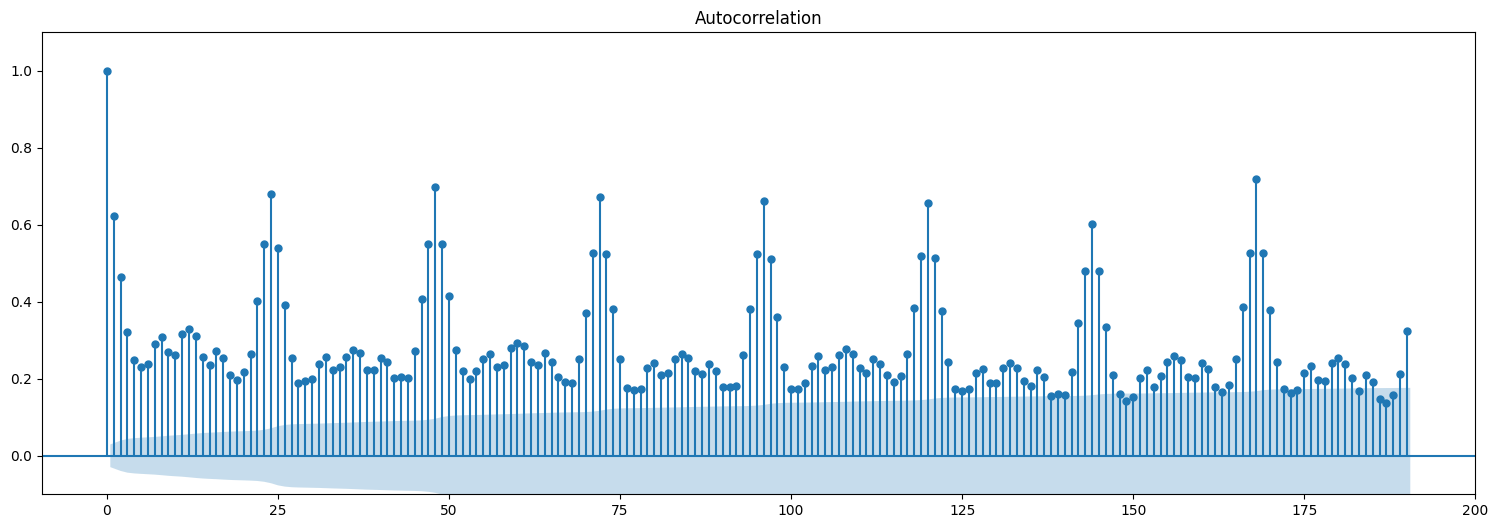

In [55]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()



In [51]:
import plotly.graph_objects as go

# Вычисляем автокорреляцию
acf_values = tsaplots.acf(ts, nlags=190)

# Создаем интерактивный график ACF
fig = go.Figure(data=go.Scatter(x=list(range(len(acf_values))), y=acf_values, mode='lines'))

# Настройки внешнего вида графика
fig.update_layout(
    title='ACF (Autocorrelation Function)',
    xaxis_title='Lag',
    yaxis_title='ACF Value',
    width=1000,
    height=400
)

# Отображаем график
fig.show()

## Тестирование

Константная модель

In [265]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_test.iloc[-1]

In [267]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))

RMSE DummyRegressor равен: 84.78


Код падает с ошибкой. Что на сделать?

In [269]:
%%time
se = s_ensemble.best_estimator_.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, se))
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 35.21
CPU times: user 1.92 s, sys: 312 ms, total: 2.24 s
Wall time: 81.1 ms


Значение метрики RMSE на тестовой выборке не больше 48, мы справились с задачей.

In [ ]:
x = y_test.values
y = se.astype(int)
data = pd.DataFrame({'true': x, 'predict': y}).set_index(y_test.index)
plotly_df(data, title='Сравнение предсказания и факта')
plt.show('svg')

Наша модель хорошо справляется с задачей, но есть замечания по пикам, их модель не предсказала.

Вывод

проверка всех моделей на тестовой выборке дала адекватный результат и у всех моделей результаты близки друг к другу
- наименьшее значение RMSE у модели catboost (RMSE=27.57)
- Но также получилось показатель rmse используя ансамбль моделей catboost, lgbm, ridge (RMSE=26.93)
- RMSE при проверке модели на адекватность: 58.88
- значение метрики лучшей модели показала результат лучше, чем требовалось в техзадании (RMSE менее 48), а значит, цель достигнута

Краткий обзор проделанной работы

В данной работе выполнены ссновные шаги:

- загружены и изучены данные
- проведена преобработка данных (ресемплирование по одному часу)
- проведен анализ имеющихся данных:
- проверка на последовательность дат
- изучены временные промежутки
- построены скользящие средние с размером окна в 24ч
- изучены тренды и сезонность
- построены разности временного ряда
- выполнена подготовка к обучению моделей:
- созданы дополнительные признаки
- данные разделены на выборки (обучающую и тестовую в соотношении 0.9/0.1)
- подготовлены категориальные и числовые признаки
- oбучены три модели (Ridge,
 CatBoostRegressor, LightGBM) и получены по ним результаты метрики RMSE
- обучен ансамбль наших трех моделей

- Выполнена проверка модели на адекватность
